In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller, kpss

data = pd.read_csv('https://raw.githubusercontent.com/signature95/tistory/main/dataset/divvy_daily.csv', index_col = 'date') 
data.head()

,rides,temperature,weather
date,,,
1/1/2014,95,19.483158,rain or snow
1/2/2014,111,16.833333,rain or snow
1/3/2014,6,-5.633333,clear
1/4/2014,181,30.007735,rain or snow
1/5/2014,32,16.756250,rain or snow


# 차분 시행

1차 차분

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbZn2AE%2FbtqARW3RxDq%2FDLtUZnZYPpbEJq7ePdTqw0%2Fimg.png)

2차 차분

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdPhBap%2FbtqAWbywcy6%2FqKCb8umEGTd9CoNeTVEdnk%2Fimg.png)

In [11]:
rides = data["rides"].to_frame(name="rides") # 데이터의 행을 역순으로 뒤집는 부분 
rides = rides.loc[::-1]
rides["lag_1"] = rides["rides"].shift(periods=1) 

print(rides)

            rides   lag_1
date                     
12/31/2017    593     NaN
12/30/2017    519   593.0
12/29/2017   1049   519.0
12/28/2017   1267  1049.0
12/27/2017   1117  1267.0
...           ...     ...
1/5/2014       32     1.0
1/4/2014      181    32.0
1/3/2014        6   181.0
1/2/2014      111     6.0
1/1/2014       95   111.0

[1458 rows x 2 columns]


In [12]:
rides['직접 구한 diff_1'] = rides['rides'] - rides['lag_1'] 
rides['함수로 구한 diff_1'] = rides['rides'].diff(1) 
print(rides)

            rides   lag_1  직접 구한 diff_1  함수로 구한 diff_1
date                                                  
12/31/2017    593     NaN           NaN            NaN
12/30/2017    519   593.0         -74.0          -74.0
12/29/2017   1049   519.0         530.0          530.0
12/28/2017   1267  1049.0         218.0          218.0
12/27/2017   1117  1267.0        -150.0         -150.0
...           ...     ...           ...            ...
1/5/2014       32     1.0          31.0           31.0
1/4/2014      181    32.0         149.0          149.0
1/3/2014        6   181.0        -175.0         -175.0
1/2/2014      111     6.0         105.0          105.0
1/1/2014       95   111.0         -16.0          -16.0

[1458 rows x 4 columns]


In [13]:
rides["diff_1"] = rides["함수로 구한 diff_1"]
rides = rides.drop(columns=['함수로 구한 diff_1', '직접 구한 diff_1'])

print(rides)

            rides   lag_1  diff_1
date                             
12/31/2017    593     NaN     NaN
12/30/2017    519   593.0   -74.0
12/29/2017   1049   519.0   530.0
12/28/2017   1267  1049.0   218.0
12/27/2017   1117  1267.0  -150.0
...           ...     ...     ...
1/5/2014       32     1.0    31.0
1/4/2014      181    32.0   149.0
1/3/2014        6   181.0  -175.0
1/2/2014      111     6.0   105.0
1/1/2014       95   111.0   -16.0

[1458 rows x 3 columns]


In [14]:
rides['diff_1 + lag_1'] = rides['diff_1'].shift(1)

In [16]:
rides['diff_1 + lag_1'] = rides['diff_1'].shift(1)
rides['직접 구한 diff_2'] = rides['diff_1'] - rides['diff_1 + lag_1']
rides['함수로 구한 diff_2'] = rides['rides'].diff().diff()

print(rides)

            rides   lag_1  diff_1  diff_1 + lag_1  직접 구한 diff_2  함수로 구한 diff_2
date                                                                          
12/31/2017    593     NaN     NaN             NaN           NaN            NaN
12/30/2017    519   593.0   -74.0             NaN           NaN            NaN
12/29/2017   1049   519.0   530.0           -74.0         604.0          604.0
12/28/2017   1267  1049.0   218.0           530.0        -312.0         -312.0
12/27/2017   1117  1267.0  -150.0           218.0        -368.0         -368.0
...           ...     ...     ...             ...           ...            ...
1/5/2014       32     1.0    31.0          -830.0         861.0          861.0
1/4/2014      181    32.0   149.0            31.0         118.0          118.0
1/3/2014        6   181.0  -175.0           149.0        -324.0         -324.0
1/2/2014      111     6.0   105.0          -175.0         280.0          280.0
1/1/2014       95   111.0   -16.0           105.0   

# 차분 결과 시각화

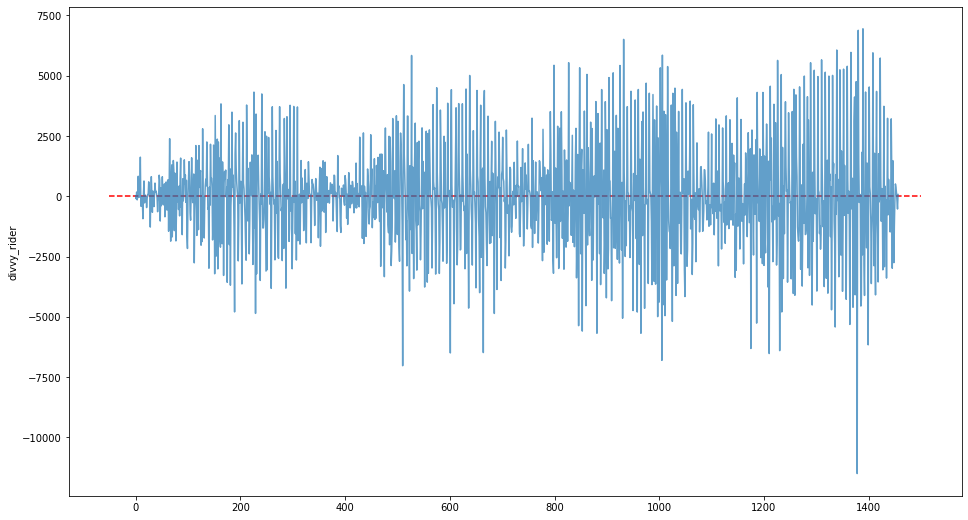

In [17]:
diff_data = data['rides'].diff(1).dropna() 

# 표 그리기 
plt.figure(figsize=(16,9)) 
plt.plot(diff_data.values, alpha=.7) 
plt.hlines(y=diff_data.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed') 
plt.ylabel('divvy_rider') 
plt.show()



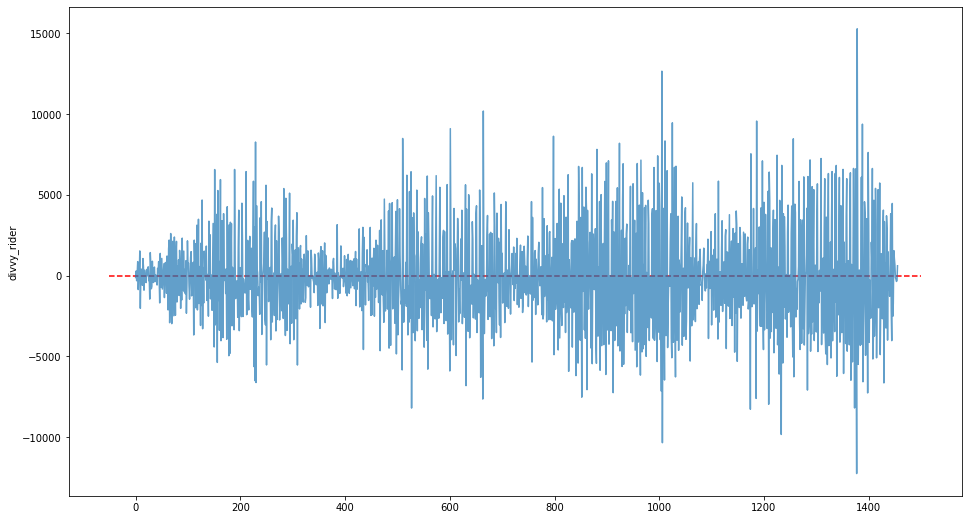

In [18]:
diff_data = data['rides'].diff().diff().dropna() 

# 표 그리기 
plt.figure(figsize=(16,9)) 
plt.plot(diff_data.values, alpha=.7) 
plt.hlines(y=diff_data.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed') 
plt.ylabel('divvy_rider') 
plt.show()

# 정상성 검정

In [25]:
# 함수 형성 
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option) 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value 
    
    print (dfoutput) 
    if dfoutput[1] < pvalue: print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.") 
    else: 
        print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.") 
        
# adf 함수를 통해 출력 (차분 X)
adf_test(data['rides'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.683520
p-value                           0.758045
Lags Used                        22.000000
Number of Observations Used    1435.000000
Critical Value (1%)              -3.965093
Critical Value (5%)              -3.413554
Critical Value (10%)             -3.128854
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.


In [26]:
# 1차 차분 적용 후 검정
adf_test(diff_data)

Results of Dickey-Fuller Test:
Test Statistic                  -16.522971
p-value                           0.000000
Lags Used                        23.000000
Number of Observations Used    1432.000000
Critical Value (1%)              -3.965106
Critical Value (5%)              -3.413560
Critical Value (10%)             -3.128858
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


In [22]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'): 
    print ('Results of KPSS Test:') 
    kpsstest = kpss(timeseries, regression= regression_option) 
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used']) 
    for key,value in kpsstest[3].items(): 
        kpss_output['Critical Value (%s)'%key] = value 
    print (kpss_output) 
    if kpss_output[1] < pvalue: print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.") 
    else: print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.") 
    
kpss_test(data['rides'])

Results of KPSS Test:
Test Statistic            0.103919
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [27]:
# 1차 차분 적용 후 검정
kpss_test(diff_data)

Results of KPSS Test:
Test Statistic            0.021147
p-value                   0.100000
Lags Used                54.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
